# Text Classification

In [451]:
import nltk
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm
import numpy as np
from wordcloud import WordCloud
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from nltk.stem import WordNetLemmatizer 
import string, re
from gensim.utils import simple_preprocess
import gensim
from gensim import corpora,models
import pickle
import spacy
from tqdm import tqdm
pd.set_option('display.max_columns',300)
pd.set_option('display.max_rows',300)

## Preprocessing & Cleaning

In [2]:
df1=pd.read_csv('2019_EN_catalog_-_Jul_to_Sep.csv',encoding= 'unicode_escape')
df2=pd.read_csv('2019_EN_catalog_-_Oct_to_Dec.csv',encoding= 'unicode_escape')

In [3]:
df=pd.concat([df1,df2], axis=0).reset_index().rename(columns={'index': 'ID'})
df.head()

ID                                      Product Title   Product Author  \
0   0  'The Loudest Voice': Wondering About THAT Open...       Joyce Chen   
1   1  [Clone] A Coldness in the Blood: The New Dracu...  Fred Saberhagen   
2   2  [Clone] A Matter of Policy: An Amy Brewster My...   Sam Merwin Jr.   
3   3  [Clone] Any Way the Wind Blows: A Novel (Unabr...   E. Lynn Harris   
4   4                   [Clone] Jack & Jill (Unabridged)  James Patterson   

                               Product Narrator Product Publisher Name  \
0                                            ""           Cosmopolitan   
1                              Robin Bloodworth        Audible Studios   
2                                Janelle Bigham   Wordwooze Publishing   
3  Dominic Hoffman, Bahni Turpin, Mirron Willis     Random House Audio   
4                  Ron Butler, Maxwell Hamilton         Hachette Audio   

  Product Primary Category Product Primary Sub Category  \
0                      NaN                          NaN   
1         Sci-Fi & Fantasy          Fantasy: Paranormal   
2    Mysteries & Thrillers                     Suspense   
3                  Fiction                 Contemporary   
4    Mysteries & Thrillers                Psychological   

                            Product Long Description  
0                          <p>This should help. </p>  
1  <p>The Bram Stoker Award-Winning saga continue...  
2  <p><i>A Matter of Policy </i>is an enthralling...  
3  <p>At the end of <i>Not a Day Goes By</i>, the...  
4  <p><b>Available as an unabridged audiobook for...

In [4]:
df.shape

(41794, 8)

In [5]:
df.isna().sum()

ID                                 0
Product Title                      0
Product Author                     0
Product Narrator                   0
Product Publisher Name             0
Product Primary Category        7087
Product Primary Sub Category    7087
Product Long Description        5396
dtype: int64

In [6]:
df.dropna(subset = ['Product Long Description'], inplace = True)

In [7]:
df.dropna(subset = ['Product Primary Category'], inplace = True)

In [8]:
df.drop(columns=[ 'Product Narrator', 'Product Publisher Name', 'Product Primary Sub Category'], inplace=True)

In [9]:
df=df[(df['Product Primary Category'] != 'Parents & Family') & (df['Product Primary Category'] != 'Products') & (df['Product Primary Category'] != 'Professionals') & (df['Product Primary Category'] != 'Students') & (df['Product Primary Category'] != 'Merchandising ') & (df['Product Primary Category'] != 'Short Stories') & (df['Product Primary Category'] != 'VERIFICATION NODES1')& (df['Product Primary Category'] != 'Merchandising')]                                                                    
                                                                                                                 

In [10]:
df.head(5)

ID                                      Product Title  \
1   1  [Clone] A Coldness in the Blood: The New Dracu...   
2   2  [Clone] A Matter of Policy: An Amy Brewster My...   
3   3  [Clone] Any Way the Wind Blows: A Novel (Unabr...   
4   4                   [Clone] Jack & Jill (Unabridged)   
5   5            [Clone] The Book of Mormon (Unabridged)   

              Product Author Product Primary Category  \
1            Fred Saberhagen         Sci-Fi & Fantasy   
2             Sam Merwin Jr.    Mysteries & Thrillers   
3             E. Lynn Harris                  Fiction   
4            James Patterson    Mysteries & Thrillers   
5  Joseph Smith - translator  Religion & Spirituality   

                            Product Long Description  
1  <p>The Bram Stoker Award-Winning saga continue...  
2  <p><i>A Matter of Policy </i>is an enthralling...  
3  <p>At the end of <i>Not a Day Goes By</i>, the...  
4  <p><b>Available as an unabridged audiobook for...  
5  <p>The Book of Mormon is a sacred text of the ...

In [11]:
df.shape

(34702, 5)

In [12]:
df.sort_values("Product Title", inplace = True) 

In [13]:
df.drop_duplicates(subset ="Product Title", 
                     keep = False, inplace = True) 

In [14]:
df=df.reset_index()

In [15]:
df.drop(columns='index',inplace=True)

In [16]:
df.shape

(34330, 5)

In [17]:
df.isna().sum()

ID                          0
Product Title               0
Product Author              0
Product Primary Category    0
Product Long Description    0
dtype: int64

In [18]:
df.shape

(34330, 5)

In [19]:
data = df['Product Long Description']

In [20]:
sw_list = stopwords.words('english')
sw_list += list(string.punctuation)
sw_list += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘', '-', '–', '—','li','/li',"n't",
            'p','/p','/i','b','/b',"'s",'br','>','<','i','/','A','\x92','\x92s','\x92ll','.com','\x97',
           '\x97s','\x93','\x94','']
#             'author','book','stories','one','new','two','best',
#             'even','never','ever','men','man','girl','women','woman','get','people','would','also']
sw_set = set(sw_list)

In [21]:
def noun_article(article):
    nouns = nltk.word_tokenize(article)
    tagged = nltk.pos_tag(nouns)
    length = len(tagged) - 1
    noun_only = list()
    for i in range(0, length):
        log = (tagged [i][1][0] == 'N')
        if log == True:
            noun_only.append(tagged [i][0])
    stopwords_removed = [n.lower() for n in noun_only if n.lower() not in sw_set]
    return stopwords_removed

In [22]:
# applying the above function to our data/features 
processed_data = list(map(noun_article, data))

In [23]:
file = open('processed_data.p', 'wb')
pickle.dump(processed_data,file)
file.close()

In [24]:
file = open('processed_data.p', 'rb')
processed_data = pickle.load(file)
file.close()
processed_data

[['room',
  'inn',
  'humanity',
  'garden',
  'eden',
  'believers',
  'crown-wearers',
  'heaven',
  'god\x92s',
  'word',
  'trials',
  'temptations',
  'god',
  'kingdom',
  'reward',
  'system.',
  'trials',
  'life',
  'faith',
  'character',
  'goal',
  'foremost',
  'trials',
  'way',
  'god\x92s',
  'plan',
  'purpose',
  'lives',
  'satan\x92s',
  'weapon',
  'ignorance',
  'god\x92s',
  'word',
  'scriptural',
  'truth',
  'threshold',
  'decision',
  'life',
  'promises',
  'principles',
  'provisions',
  'will.',
  'scripture',
  'spirit',
  'fellowship',
  'suffering',
  'image',
  'power',
  'resurrection',
  'path',
  'life',
  'jesus',
  'word',
  'fact',
  'word.',
  'furthermore',
  'room',
  'inn',
  'jesus',
  'didn\x92t',
  'purpose',
  'remember',
  'innkeeper',
  'heart',
  'vacancy',
  'sign.'],
 ['hollywood',
  'meant',
  'jessica',
  'dawson',
  'assistant',
  'agents',
  'town',
  'tongue',
  'untruths',
  'occurrence',
  'realities',
  'life',
  'months',
 

In [25]:
total_vocab = set()
for comment in processed_data:
    total_vocab.update(comment)
len(total_vocab)

87859

In [26]:
new_processed_data = [' '.join(w) for w in processed_data]

In [27]:
new_processed_data

['room inn humanity garden eden believers crown-wearers heaven god\x92s word trials temptations god kingdom reward system. trials life faith character goal foremost trials way god\x92s plan purpose lives satan\x92s weapon ignorance god\x92s word scriptural truth threshold decision life promises principles provisions will. scripture spirit fellowship suffering image power resurrection path life jesus word fact word. furthermore room inn jesus didn\x92t purpose remember innkeeper heart vacancy sign.',
 'hollywood meant jessica dawson assistant agents town tongue untruths occurrence realities life months lie gran lay deathbed jessica soul mate gran\x92s grandkids jesus jessica didn\x92t heart one gran recovery gran jessica\x92s man cousin\x92s wedding man fast professional solution enter dave larsson brother hollywood\x92s sexy funny sibling talent charm dave home gran family wedding admit lie thing plan lie time',
 'love larsson boys maya\x92s adolescent crush friend. alex larsson. she\x

In [28]:
def article(text):
    text = re.sub(r'\<[\w/]+\>', '', text)
    text = text.replace("\x92",'')
    text = text.replace("\x93",'')
    text = text.replace("\x94",'')
    text = text.replace("\x91",'')
    text = text.replace("\x97",'')
    text = text.replace("/ul",'')
    text = text.replace("(Unabridged)",'')
    text = text.replace("#",'')
    text = text.replace("[Clone]",'')
    return text

In [29]:
new_title_list = list(map(article,df['Product Title']))

In [30]:
new_title=pd.DataFrame(new_title_list)

In [31]:
df['Product Title'] = new_title

In [35]:
file = open('df.p', 'wb')
pickle.dump(df,file)
file.close()

In [36]:
file = open('df.p', 'rb')
df = pickle.load(file)
file.close()
df

ID                                      Product Title  \
0      18976   "No Room in the Inn?": The Fiery Trials of Li...   
1          0                                             1 Lie    
2          1                                            1 Love    
3          2                                            1 Muse    
4      11621  1 in Customer Service: The Complete Adventures...   
...      ...                                                ...   
34325    279  Psychological fear: MIT scientists of Chinese ...   
34326   2671  The Tears Were Real. Ryan Murphy and Janet Moc...   
34327   8635  Tropical Trump sparks unprecedented crisis for...   
34328  10713  We Are Being Eaten From Within. Why America Is...   
34329  13386    Union Berlin "finally there" in the Bundesliga    

         Product Author Product Primary Category  \
0           Brad Wyrick  Religion & Spirituality   
1            T. Gephart                  Romance   
2            T. Gephart                  Romance   
3            T. Gephart                  Romance   
4         Larry Correia         Sci-Fi & Fantasy   
...                 ...                      ...   
34325       Elie Dolgin   Newspapers & Magazines   
34326       Judy Berman   Newspapers & Magazines   
34327    Jeff Tollefson   Newspapers & Magazines   
34328  Vera Bergengruen   Newspapers & Magazines   
34329          FIFA.com     Arts & Entertainment   

                                Product Long Description  
0      <p><i># "No Room in the Inn?"</i> will take us...  
1      <p>Working in Hollywood meant Jessica Dawson w...  
2      <p>It was easy to fall in love with a Larsson ...  
3      <p>Landing a writing gig in Hollywood was just...  
4      <p>No alien menace is too menacing, no galacti...  
...                                                  ...  
34325  <p>Researchers describe how a government crack...  
34326  <p>Warning: This piece contains spoilers for t...  
34327  <p>Tensions are rising as Jair Bolsonaros adm...  
34328  <p>Even before the shooting at an El Paso Walm...  
34329  <p>Union Berlin "finally there" in the Bundesl...  

[34330 rows x 5 columns]

In [37]:
final_noun_list = list(map(article, new_processed_data))

### lemmatization

In [38]:
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer() 

In [39]:
# creating a list with all lemmatized outputs
lemmatized_output = []

for listy in final_noun_list:
    lemmed = ' '.join([lemmatizer.lemmatize(w) for w in listy.split()])
    lemmatized_output.append(lemmed)

In [40]:
final_noun_list_lemmatizd = lemmatized_output

In [41]:
file = open('final_noun_list_lemmatizd.p', 'wb')
pickle.dump(final_noun_list_lemmatizd,file)
file.close()

In [345]:
data

0        <p><i># "No Room in the Inn?"</i> will take us...
1        <p>Working in Hollywood meant Jessica Dawson w...
2        <p>It was easy to fall in love with a Larsson ...
3        <p>Landing a writing gig in Hollywood was just...
4        <p>No alien menace is too menacing, no galacti...
                               ...                        
34325    <p>Researchers describe how a government crack...
34326    <p>Warning: This piece contains spoilers for t...
34327    <p>Tensions are rising as Jair Bolsonaros adm...
34328    <p>Even before the shooting at an El Paso Walm...
34329    <p>Union Berlin "finally there" in the Bundesl...
Name: Product Long Description, Length: 34330, dtype: object

In [42]:
file = open('final_noun_list_lemmatizd.p', 'rb')
final_noun_list_lemmatizd = pickle.load(file)
file.close()
final_noun_list_lemmatizd

['room inn humanity garden eden believer crown-wearers heaven god word trial temptation god kingdom reward system. trial life faith character goal foremost trial way god plan purpose life satan weapon ignorance god word scriptural truth threshold decision life promise principle provision will. scripture spirit fellowship suffering image power resurrection path life jesus word fact word. furthermore room inn jesus didnt purpose remember innkeeper heart vacancy sign.',
 'hollywood meant jessica dawson assistant agent town tongue untruth occurrence reality life month lie gran lay deathbed jessica soul mate gran grandkids jesus jessica didnt heart one gran recovery gran jessicas man cousin wedding man fast professional solution enter dave larsson brother hollywood sexy funny sibling talent charm dave home gran family wedding admit lie thing plan lie time',
 'love larsson boy maya adolescent crush friend. alex larsson. shed theyd maya hadnt criminal mistress side. banished la life larsson b

## EDA

In [43]:
labels = df['Product Primary Category'].values

In [44]:
df['Product Primary Category'].value_counts().sort_values(ascending=False)

Self Development           4782
Romance                    4501
Newspapers & Magazines     3290
Mysteries & Thrillers      2693
Sci-Fi & Fantasy           2604
Fiction                    1950
Teens                      1785
Religion & Spirituality    1509
Science & Technology       1409
Business                   1380
Kids                       1213
Nonfiction                 1117
Erotica & Sexuality         961
Bios & Memoirs              954
History                     902
Health & Fitness            752
Sports                      527
Arts & Entertainment        411
Nostalgia Radio             338
Classics                    337
Language Instruction        224
Drama & Poetry              204
Travel & Adventure          163
Comedy                      121
Radio & TV                  109
Live Events                  61
Kids & Young Adults          33
Name: Product Primary Category, dtype: int64

Text(0.5, 1.0, 'Distribution Of Genres')

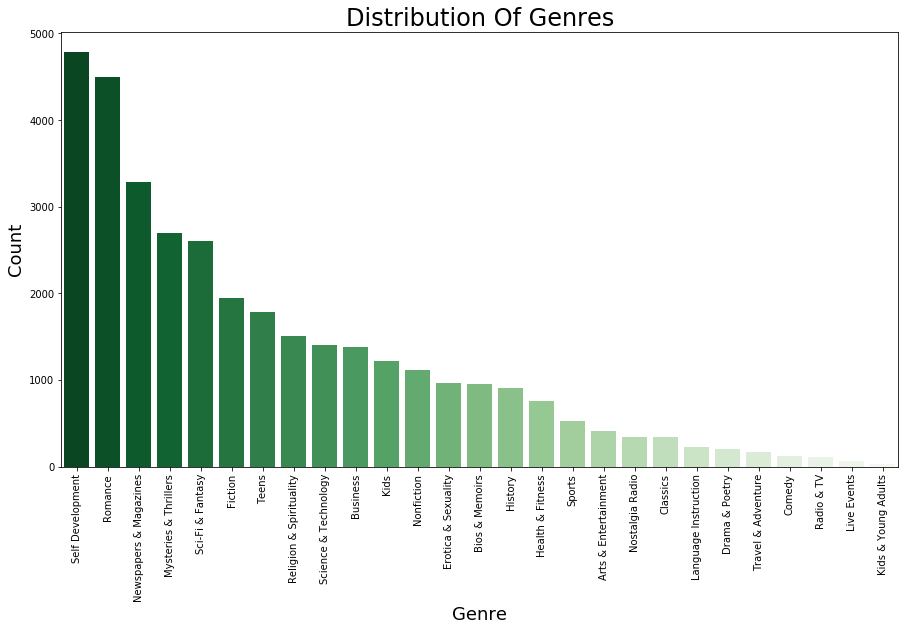

In [46]:
plt.figure(figsize = (15,8))
g=sns.countplot(x =labels, palette="Greens_r",order = df['Product Primary Category'].value_counts().index)
g.set(xticklabels=['Self Development', 'Romance', 'Newspapers & Magazines','Mysteries & Thrillers','Sci-Fi & Fantasy','Fiction','Teens','Religion & Spirituality','Science & Technology','Business','Kids','Nonfiction','Erotica & Sexuality','Bios & Memoirs','History','Health & Fitness','Sports','Arts & Entertainment','Nostalgia Radio','Classics','Language Instruction','Drama & Poetry','Travel & Adventure','Comedy','Radio & TV','Live Events','Kids & Young Adults'])
plt.xticks(rotation=90)
plt.xlabel('Genre',fontsize=18)
plt.ylabel('Count',fontsize=18)
plt.title('Distribution Of Genres', fontsize=24)

In [47]:
word_count = df['Product Long Description'].apply(lambda x:len(x.split()))
print('mean:', word_count.mean())
print('25 quantile:', word_count.quantile(0.25))
print('75 quantile:', word_count.quantile(0.75))

mean: 158.85295659772794
25 quantile: 86.0
75 quantile: 227.0


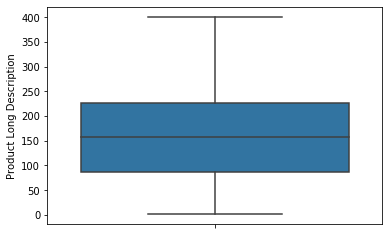

In [48]:
sns.boxplot(y=word_count, showfliers=False)

In [49]:
df['word_count'] = word_count
df.head()

ID                                      Product Title Product Author  \
0  18976   "No Room in the Inn?": The Fiery Trials of Li...    Brad Wyrick   
1      0                                             1 Lie      T. Gephart   
2      1                                            1 Love      T. Gephart   
3      2                                            1 Muse      T. Gephart   
4  11621  1 in Customer Service: The Complete Adventures...  Larry Correia   

  Product Primary Category                           Product Long Description  \
0  Religion & Spirituality  <p><i># "No Room in the Inn?"</i> will take us...   
1                  Romance  <p>Working in Hollywood meant Jessica Dawson w...   
2                  Romance  <p>It was easy to fall in love with a Larsson ...   
3                  Romance  <p>Landing a writing gig in Hollywood was just...   
4         Sci-Fi & Fantasy  <p>No alien menace is too menacing, no galacti...   

   word_count  
0         228  
1         240  
2         196  
3         327  
4         280

Text(0, 0.5, 'word count')

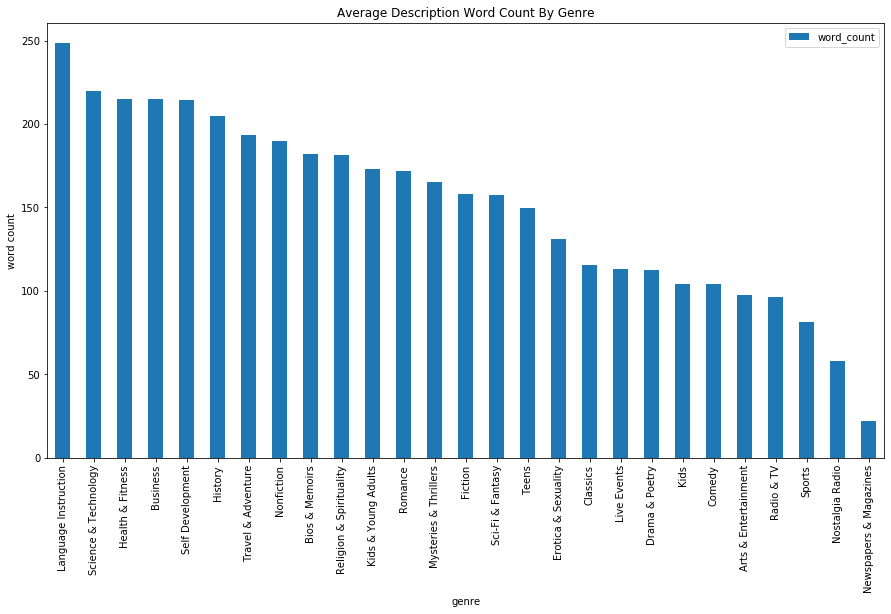

In [50]:
a=df.groupby(['Product Primary Category'])['word_count'].mean()
ax = pd.DataFrame(a.sort_values(ascending=False)).plot(kind='bar',figsize =(15,8),use_index=bool,title='Average Description Word Count By Genre')
ax.set_xlabel('genre')
ax.set_ylabel('word count')


In [51]:
pd.DataFrame(a)

word_count
Product Primary Category            
Arts & Entertainment       97.618005
Bios & Memoirs            182.057652
Business                  214.697826
Classics                  115.554896
Comedy                    103.950413
Drama & Poetry            112.627451
Erotica & Sexuality       131.213319
Fiction                   157.928718
Health & Fitness          215.043883
History                   204.633038
Kids                      104.253916
Kids & Young Adults       173.060606
Language Instruction      248.294643
Live Events               112.950820
Mysteries & Thrillers     164.893799
Newspapers & Magazines     22.075988
Nonfiction                189.811101
Nostalgia Radio            57.843195
Radio & TV                 96.366972
Religion & Spirituality   181.395626
Romance                   171.945123
Sci-Fi & Fantasy          157.346774
Science & Technology      220.037615
Self Development          214.567336
Sports                     81.223909
Teens                     149.718768
Travel & Adventure        193.368098

In [52]:
eda = df.sample(n=1000, replace=False, random_state=10)

In [53]:
total_description=[]
for i in eda['Product Long Description']:
    total_description.append(i)
    list_to_str = ' '.join([str(elem) for elem in total_description])
list_to_str = list_to_str.replace('\x92s','')
list_to_str = list_to_str.replace('</p>','')
list_to_str = list_to_str.replace('<p>','')
list_to_str = list_to_str.replace('<ul>','')
list_to_str = list_to_str.replace('</ul>','')
list_to_str = list_to_str.replace('<li>','')
list_to_str = list_to_str.replace('</li>','')
list_to_str = list_to_str.replace('</i>','')
list_to_str = list_to_str.replace('<i>','')
list_to_str = list_to_str.replace('<b>','')
list_to_str = list_to_str.replace('</b>','')
list_to_str = list_to_str.replace('</>','')
list_to_str = list_to_str.replace("\'s",'')
list_to_str = list_to_str.replace("\'t",'')
list_to_str = list_to_str.replace("\x93",'')
list_to_str = list_to_str.replace("\x94",'')
list_to_str = list_to_str.replace("\x92",'')
list_to_str                        

'Do you want to learn about dialysis recipes? Do you want to know how to prepare the most delicious meals that fit your diet?In this cookbook, you will find:Side dish recipes likeVeggie burgersGlazed carrotsGinger soupSalad recipes likeApple rice saladBeet saladCobb saladAnd many other recipes!Here is a preview of what you\'ll learn....How to cook healthy mealsComprehensive dietary advice and guidanceRecipes with detailed instructionsEach recipe contains the exact amount of calories, protein, carbohydrates, and fatFast and easy prep that requires no additional steps to prepare your mealTips and tricksMuch, much more!Dont miss out on Dialysis Cookbook! Although the presidential election of 1944 placed FDR in the White House for an unprecedented fourth term, historical memory of the election itself has been overshadowed by the war, Roosevelt health and his death the following April, Truman ascendancy, and the decision to drop the atomic bomb. Today most people assume that FDR reelection 

In [54]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')

tokenized_review = tokenizer.tokenize(list_to_str)

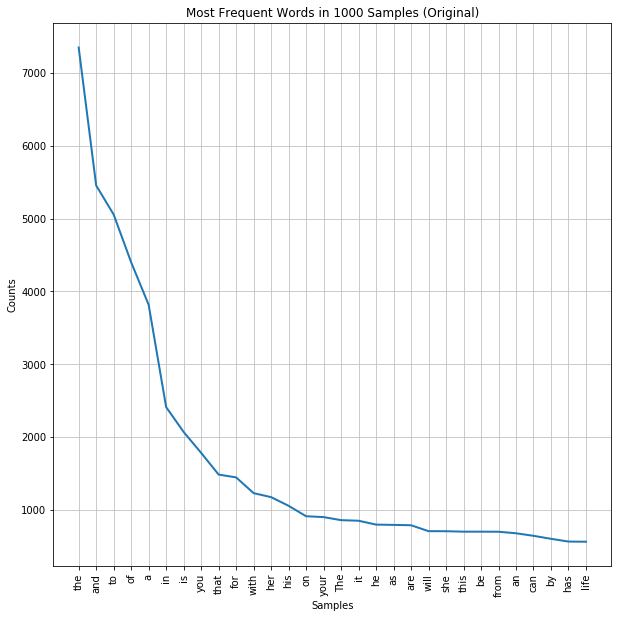

In [55]:
fdist = FreqDist(tokenized_review)
plt.figure(figsize=(10,10))
plt.title('Most Frequent Words in 1000 Samples (Original)')
fdist.plot(30)

In [56]:
noun_list = noun_article(list_to_str)

In [69]:
list_to_str2 = ' '.join([str(elem) for elem in noun_list])
list_to_str2 = list_to_str2.replace('\x92s','')
list_to_str2

"dialysis recipes meals cookbook recipes carrotsginger soupsalad rice saladbeet recipes preview advice guidancerecipes instructionseach recipe amount calories protein carbohydrates fatfast prep steps mealtips dont dialysis cookbook election fdr white house term memory election war roosevelt health death april truman ascendancy decision bomb people fdr reelection david m. jordan account reveals outcome campaign choice candidates week election day pollster george gallup shift votes states election thomas e. dewey democrats voters horses midstream republicans war quicker dewey bricker insider tales accounts party politics votes shadow war future fdr dewey election chapter history.the book indiana university press audiobook university press audiobooks narrative journal american history jordan style intl social science review fun volume contest karl rove meditation moments mountain visualization practice ground dormant years killer strikes clues way fbi agent riley paige riddles women thril

In [70]:
tokenized_review2 = tokenizer.tokenize(list_to_str2)

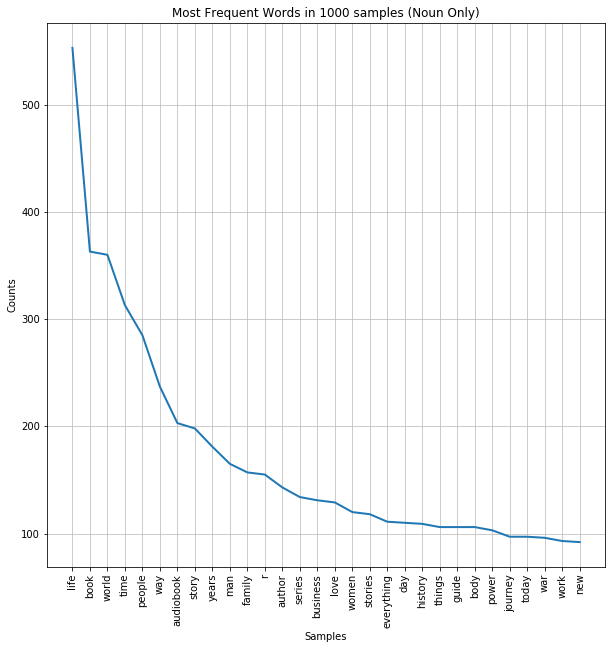

In [71]:
fdist2 = FreqDist(tokenized_review2)
plt.figure(figsize=(10,10))
plt.title('Most Frequent Words in 1000 samples (Noun Only)')
fdist2.plot(30)

### Most Frequent Words

In [72]:
df_freq_ficiton = df[df['Product Primary Category']=='Fiction']
df_freq_nonficiton = df[df['Product Primary Category']=='Nonfiction']

In [73]:
data_fiction = df_freq_ficiton['Product Long Description']
data_nonfiction = df_freq_nonficiton['Product Long Description']

In [74]:
pros_fiction = list(map(noun_article, data_fiction))
pros_nonfiction = list(map(noun_article, data_nonfiction))

In [75]:
total_vocab_fiction = set()
total_vocab_nonfiction = set()
for comment in pros_fiction:
    total_vocab_fiction.update(comment)
for comment in pros_nonfiction:
    total_vocab_nonfiction.update(comment)
print(len(total_vocab_fiction))
print(len(total_vocab_nonfiction))

19388
14718


In [76]:
print(pros_fiction[:2])

[['climate', 'change', 'water', 'crisis', 'china', 'prairie', 'provinces', 'river', 'water', 'hudson', 'bay', 'beijing', 'passage', 'year-round', 'story', 'insights', 'canada', 'water', 'resources', 'geography', 'history.', 'environmentalists', 'north', 'canada', 'water', 'resources', 'jeremiah', 'coffey', 'us', 'president', 'chinese', 'canada', 'columbia', 'united', 'states', 'drought', 'americans', 'water', 'california', 'british', 'columbia', 'rivers', 'us', 'state', 'department', 'cia', 'tactics', 'lee', 'girard', 'asset', 'field.', 'green', 'party', 'power', 'months', 'sheila', 'thompson', 'prime', 'minister', 'canada', 'chinese', 'occupation', 'meddling', 'minister', 'national', 'defence', "'rolly", "o'brien", 'salty', 'newfoundlander', 'korean', 'war.', 'canadian', 'chief', 'defence', 'staff', 'general', 'robert', 'fraser', 'husband', 'to-be', 'staff', 'stuart', 'mcgee', 'everything', 'plan', 'chinese', 'remembrance', 'day', 'prime', 'minister', 'post', 'brexit', 'woes', 'collap

In [77]:
print(pros_nonfiction[:2])

[['milestone', 'crime', 'hall-mills', 'case', 'new', 'brunswick', 'new', 'jersey', 'decade', 'killer', 'case', 'aficionados', 'bon', 'vivant', 'episcopal', 'minister', 'soprano', 'choir', 'wife', 'brother', 'maid', 'snooping', 'congregants', 'bumbling', 'detectives', 'denouement', 'trial', 'america\x92s', 'jazz', 'age', 'likes', 'damon', 'runyon', 'dorothy', 'dix', 'james', 'thurber', 'testimony', 'witness', 'veracity', 'farmer', 'tabloids', 'pig', 'woman', 'almost', 'everyone', 'mystery', 'secret', 'one', 'years', 'audible\x92s', 'request', 'business', 'crime', 'journalist', 'bryan', 'burrough', 'case', 'records', 'time', 'narration', 'texas', 'accent', 'immediacy', 'intimacy', 'new', 'jersey', 'crime', 'listeners', 'reconstruction', 'double-murder', 'prosecution', 'media', 'circus', 'day'], ['book', 'compilation', 'essays', 'judgments\x92', 'supreme', 'court', 'india', 'man', 'democracy', 'judgments', 'judiciary', 'system', 'author', 'attempts', 'picture', 'cases', 'maneka', 'gandhi'

In [78]:
# Preprocessing:
# We will use these again later on
# FORMAT:  flat_list = [item for sublist in l for item in sublist]

flat_fiction = [item for sublist in pros_fiction for item in sublist]
flat_nonfiction = [item for sublist in pros_nonfiction for item in sublist]

In [79]:
fiction_freq = FreqDist(flat_fiction)
nonfiction_freq = FreqDist(flat_nonfiction)

In [80]:
fiction_freq.most_common(20)

[('life', 1219),
 ('story', 763),
 ('family', 737),
 ('man', 638),
 ('world', 625),
 ('love', 531),
 ('time', 500),
 ('stories', 484),
 ('novel', 457),
 ('book', 436),
 ('author', 432),
 ('years', 402),
 ('woman', 362),
 ('war', 361),
 ('home', 361),
 ('way', 340),
 ('new', 331),
 ('father', 325),
 ('mother', 312),
 ('people', 284)]

In [81]:
nonfiction_freq.most_common(20)

[('book', 600),
 ('world', 490),
 ('people', 415),
 ('history', 399),
 ('life', 399),
 ('story', 352),
 ('years', 309),
 ('women', 309),
 ('time', 285),
 ('america', 277),
 ('new', 250),
 ('trump', 245),
 ('author', 238),
 ('audiobook', 232),
 ('stories', 213),
 ('power', 205),
 ('way', 203),
 ('war', 175),
 ('family', 172),
 ('states', 170)]

### Normalized word frequencies

In [82]:
fiction_total_word_count = sum(fiction_freq.values())
fiction_top_20 = fiction_freq.most_common(20)
print("Word \t\t Normalized Frequency")
print()
for word in fiction_top_20:
    normalized_frequency = word[1]/fiction_total_word_count
    print("{} \t\t {:.4}".format(word[0], normalized_frequency))

Word 		 Normalized Frequency

life 		 0.01228
story 		 0.007688
family 		 0.007426
man 		 0.006428
world 		 0.006297
love 		 0.00535
time 		 0.005038
stories 		 0.004877
novel 		 0.004605
book 		 0.004393
author 		 0.004353
years 		 0.00405
woman 		 0.003647
war 		 0.003637
home 		 0.003637
way 		 0.003426
new 		 0.003335
father 		 0.003275
mother 		 0.003144
people 		 0.002862


In [83]:
nonfiction_total_word_count = sum(nonfiction_freq.values())
nonfiction_top_20 = nonfiction_freq.most_common(20)
print("Word \t\t Normalized Frequency")
print()
for word in nonfiction_top_20:
    normalized_frequency = word[1]/nonfiction_total_word_count
    print("{} \t\t {:.4}".format(word[0], normalized_frequency))

Word 		 Normalized Frequency

book 		 0.008535
world 		 0.00697
people 		 0.005903
history 		 0.005676
life 		 0.005676
story 		 0.005007
years 		 0.004396
women 		 0.004396
time 		 0.004054
america 		 0.00394
new 		 0.003556
trump 		 0.003485
author 		 0.003386
audiobook 		 0.0033
stories 		 0.00303
power 		 0.002916
way 		 0.002888
war 		 0.002489
family 		 0.002447
states 		 0.002418


### visualization

In [84]:
# create counts of satire and not satire with values and words
fiction_bar_counts = [x[1] for x in fiction_freq.most_common(20)]
fiction_bar_words = [x[0] for x in fiction_freq.most_common(20)]
nonfiction_bar_counts = [x[1] for x in nonfiction_freq.most_common(20)]
nonfiction_bar_words = [x[0] for x in nonfiction_freq.most_common(20)]


In [85]:
# set the color of our bar graphs
color = cm.viridis_r(np.linspace(.4,.8, 30))

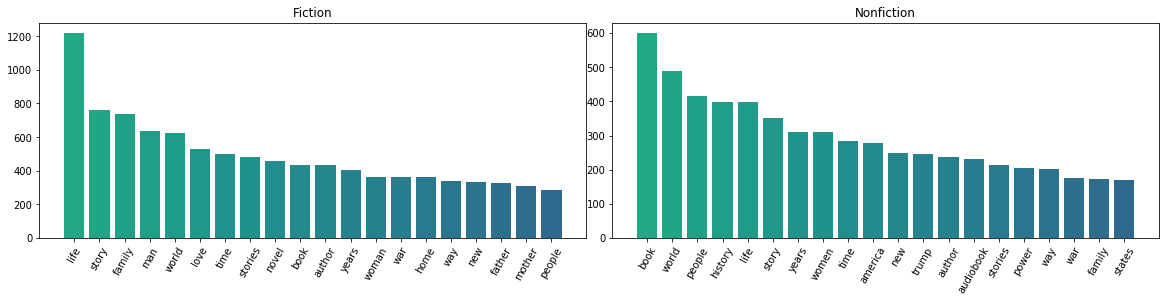

In [86]:
new_figure = plt.figure(figsize=(16,4))

ax = new_figure.add_subplot(121)
ax2 = new_figure.add_subplot(122)

# Generate a line plot on first axes
ax.bar(fiction_bar_words, fiction_bar_counts, color=color)
# ax.plot(colormap='PRGn')

# Draw a scatter plot on 2nd axes
ax2.bar(nonfiction_bar_words, nonfiction_bar_counts, color=color )

ax.title.set_text('Fiction')
ax2.title.set_text('Nonfiction')

for ax in new_figure.axes:
    plt.sca(ax)
    plt.xticks(rotation=60)

plt.tight_layout(pad=0)

# plt.savefig('word count bar graphs.png')

plt.show()

### Word Clouds

In [88]:
fiction_dictionary = dict(zip(fiction_bar_words, fiction_bar_counts))
nonfiction_dictionary = dict(zip(nonfiction_bar_words, nonfiction_bar_counts))

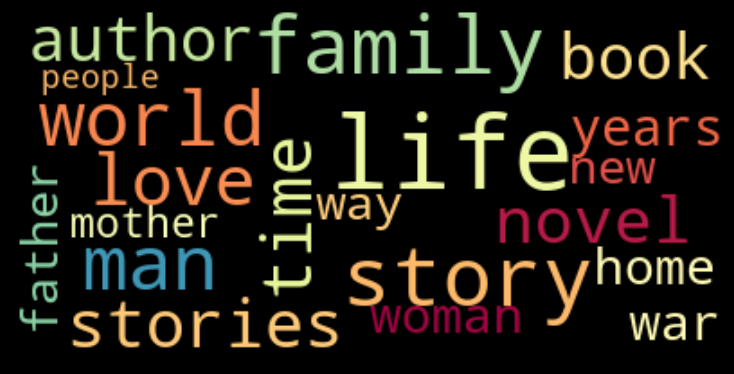

In [89]:
# Create the word cloud:

wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(fiction_dictionary)

# Display the generated image w/ matplotlib:

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

# Uncomment the next line if you want to save your image:
# plt.savefig('satire_wordcloud.png')

plt.show()

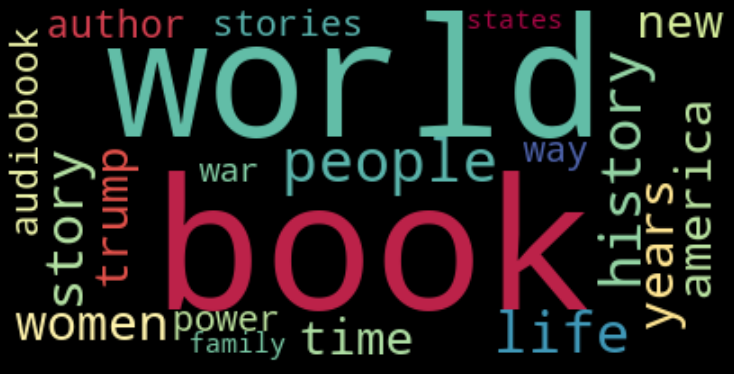

In [90]:
# Create the word cloud:

wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(nonfiction_dictionary)

# Display the generated image w/ matplotlib:

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

# Uncomment the next line if you want to save your image:
# plt.savefig('satire_wordcloud.png')

plt.show()

##  Recommendation System

### Gensim Corpus Model

In [91]:
final_noun_list_lemmatizd

['room inn humanity garden eden believer crown-wearers heaven god word trial temptation god kingdom reward system. trial life faith character goal foremost trial way god plan purpose life satan weapon ignorance god word scriptural truth threshold decision life promise principle provision will. scripture spirit fellowship suffering image power resurrection path life jesus word fact word. furthermore room inn jesus didnt purpose remember innkeeper heart vacancy sign.',
 'hollywood meant jessica dawson assistant agent town tongue untruth occurrence reality life month lie gran lay deathbed jessica soul mate gran grandkids jesus jessica didnt heart one gran recovery gran jessicas man cousin wedding man fast professional solution enter dave larsson brother hollywood sexy funny sibling talent charm dave home gran family wedding admit lie thing plan lie time',
 'love larsson boy maya adolescent crush friend. alex larsson. shed theyd maya hadnt criminal mistress side. banished la life larsson b

In [92]:
new_final_noun_list_lemmatizd = [''.join(w) for w in final_noun_list_lemmatizd]

In [93]:
final_noun_list_lemmatizd

['room inn humanity garden eden believer crown-wearers heaven god word trial temptation god kingdom reward system. trial life faith character goal foremost trial way god plan purpose life satan weapon ignorance god word scriptural truth threshold decision life promise principle provision will. scripture spirit fellowship suffering image power resurrection path life jesus word fact word. furthermore room inn jesus didnt purpose remember innkeeper heart vacancy sign.',
 'hollywood meant jessica dawson assistant agent town tongue untruth occurrence reality life month lie gran lay deathbed jessica soul mate gran grandkids jesus jessica didnt heart one gran recovery gran jessicas man cousin wedding man fast professional solution enter dave larsson brother hollywood sexy funny sibling talent charm dave home gran family wedding admit lie thing plan lie time',
 'love larsson boy maya adolescent crush friend. alex larsson. shed theyd maya hadnt criminal mistress side. banished la life larsson b

In [94]:
def preprocess_body(text):
    simple_text = simple_preprocess(text)
    text_out = [ word for word in simple_text ]
    return text_out

In [95]:
list_of_word_token = list(map(preprocess_body, final_noun_list_lemmatizd))

In [96]:
id2word = corpora.Dictionary(list_of_word_token)
id2word.filter_extremes(no_below=30,no_above=0.5,keep_n=10000)
texts = list_of_word_token
corpus = [id2word.doc2bow(text) for text in texts]

In [97]:
print(len(texts),len(id2word))

34330 5273


In [99]:
corpusdf=pd.DataFrame(gensim.matutils.corpus2dense(corpus,num_terms=5273,num_docs=34330)).T

In [100]:
corpusdf.columns=id2word.token2id

In [101]:
corpusdf['book_title']=df['Product Title']

In [103]:
file = open('corpusdf.p', 'wb')
pickle.dump(corpusdf,file)
file.close()

In [104]:
file = open('corpusdf.p', 'rb')
corpusdf = pickle.load(file)
file.close()
corpusdf

believer  character  crown  decision  didnt  eden  fact  faith  \
0           1.0        1.0    1.0       1.0    1.0   1.0   1.0    1.0   
1           0.0        0.0    0.0       0.0    1.0   0.0   0.0    0.0   
2           0.0        0.0    0.0       0.0    0.0   0.0   0.0    0.0   
3           0.0        0.0    0.0       0.0    0.0   0.0   0.0    0.0   
4           0.0        0.0    0.0       0.0    0.0   0.0   0.0    0.0   
...         ...        ...    ...       ...    ...   ...   ...    ...   
34325       0.0        0.0    0.0       0.0    0.0   0.0   0.0    0.0   
34326       0.0        0.0    0.0       0.0    0.0   0.0   0.0    0.0   
34327       0.0        0.0    0.0       0.0    0.0   0.0   0.0    0.0   
34328       0.0        0.0    0.0       0.0    0.0   0.0   0.0    0.0   
34329       0.0        0.0    0.0       0.0    0.0   0.0   0.0    0.0   

       foremost  furthermore  garden  goal  god  heart  heaven  humanity  \
0           1.0          1.0     1.0   1.0  4.0    1.0     1.0       1.0   
1           0.0          0.0     0.0   0.0  0.0    1.0     0.0       0.0   
2           0.0          0.0     0.0   0.0  0.0    0.0     0.0       0.0   
3           0.0          0.0     0.0   0.0  0.0    0.0     0.0       0.0   
4           0.0          0.0     0.0   0.0  0.0    0.0     0.0       0.0   
...         ...          ...     ...   ...  ...    ...     ...       ...   
34325       0.0          0.0     0.0   0.0  0.0    0.0     0.0       0.0   
34326       0.0          0.0     0.0   0.0  0.0    0.0     0.0       0.0   
34327       0.0          0.0     0.0   0.0  0.0    0.0     0.0       0.0   
34328       0.0          0.0     0.0   0.0  0.0    0.0     0.0       0.0   
34329       0.0          0.0     0.0   0.0  0.0    0.0     0.0       0.0   

       ignorance  image  inn  jesus  kingdom  life  path  plan  power  \
0            1.0    1.0  2.0    2.0      1.0   4.0   1.0   1.0    1.0   
1            0.0    0.0  0.0    1.0      0.0   1.0   0.0   1.0    0.0   
2            0.0    0.0  0.0    0.0      0.0   2.0   0.0   0.0    0.0   
3            0.0    0.0  0.0    0.0      0.0   2.0   0.0   0.0    0.0   
4            0.0    0.0  0.0    0.0      0.0   0.0   0.0   0.0    0.0   
...          ...    ...  ...    ...      ...   ...   ...   ...    ...   
34325        0.0    0.0  0.0    0.0      0.0   0.0   0.0   0.0    0.0   
34326        0.0    0.0  0.0    0.0      0.0   0.0   0.0   0.0    0.0   
34327        0.0    0.0  0.0    0.0      0.0   0.0   0.0   0.0    0.0   
34328        0.0    0.0  0.0    0.0      0.0   0.0   0.0   0.0    0.0   
34329        0.0    0.0  0.0    0.0      0.0   0.0   0.0   0.0    0.0   

       principle  promise  purpose  remember  resurrection  reward  room  \
0            1.0      1.0      2.0       1.0           1.0     1.0   2.0   
1            0.0      0.0      0.0       0.0           0.0     0.0   0.0   
2            0.0      0.0      0.0       0.0           0.0     0.0   0.0   
3            0.0      0.0      0.0       0.0           0.0     0.0   0.0   
4            0.0      0.0      0.0       0.0           0.0     0.0   0.0   
...          ...      ...      ...       ...           ...     ...   ...   
34325        0.0      0.0      0.0       0.0           0.0     0.0   0.0   
34326        0.0      0.0      0.0       0.0           0.0     0.0   0.0   
34327        0.0      0.0      0.0       0.0           0.0     0.0   0.0   
34328        0.0      0.0      0.0       0.0           0.0     0.0   0.0   
34329        0.0      0.0      0.0       0.0           0.0     0.0   0.0   

       satan  scripture  sign  spirit  suffering  system  temptation  trial  \
0        1.0        1.0   1.0     1.0        1.0     1.0         1.0    3.0   
1        0.0        0.0   0.0     0.0        0.0     0.0         0.0    0.0   
2        0.0        0.0   0.0     0.0        0.0     0.0         0.0    0.0   
3        0.0        0.0   0.0     0.0        0.0     0.0         0.0    0.0   
4        0.0        0.0   0.0   

### Cosine Similarity

In [106]:
from sklearn.metrics import pairwise_distances

In [107]:
cosine_sim = 1-pairwise_distances(corpusdf.drop(columns='book_title'), metric='cosine')

In [322]:
cosine_sim_df = pd.DataFrame(cosine_sim)
cosine_sim_df

0         1         2         3         4         5         6      \
0      1.000000  0.104062  0.089893  0.085280  0.006443  0.055419  0.023652   
1      0.104062  1.000000  0.085749  0.119312  0.016389  0.070485  0.180497   
2      0.089893  0.085749  1.000000  0.105409  0.007964  0.068500  0.131559   
3      0.085280  0.119312  0.105409  1.000000  0.018132  0.072783  0.177504   
4      0.006443  0.016389  0.007964  0.018132  1.000000  0.023566  0.025144   
...         ...       ...       ...       ...       ...       ...       ...   
34325  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
34326  0.000000  0.000000  0.000000  0.000000  0.000000  0.041100  0.000000   
34327  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
34328  0.000000  0.000000  0.000000  0.036515  0.000000  0.000000  0.000000   
34329  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

          7         8         9         10        11        12        13     \
0      0.020328  0.152894  0.074796  0.079455  0.165468  0.048436  0.007734   
1      0.025854  0.113436  0.023783  0.060634  0.078920  0.030802  0.108197   
2      0.150756  0.173234  0.046225  0.078567  0.127828  0.059868  0.019118   
3      0.000000  0.071714  0.070165  0.089443  0.155223  0.045437  0.021764   
4      0.000000  0.009030  0.053009  0.045049  0.043976  0.000000  0.000000   
...         ...       ...       ...       ...       ...       ...       ...   
34325  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
34326  0.000000  0.000000  0.069338  0.000000  0.000000  0.000000  0.000000   
34327  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
34328  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.033113   
34329  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

          14        15        16        17        18        19        20     \
0      0.017336  0.071067  0.101929  0.115122  0.000000  0.000000  0.127128   
1      0.055122  0.054233  0.064820  0.053244  0.000000  0.000000  0.040423   
2      0.085710  0.140546  0.062994  0.116423  0.000000  0.000000  0.078567   
3      0.065049  0.106667  0.095618  0.186535  0.000000  0.000000  0.059628   
4      0.055288  0.020147  0.018060  0.037086  0.028814  0.051081  0.022525   
...         ...       ...       ...       ...       ...       ...       ...   
34325  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
34326  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.117851   
34327  0.000000  0.000000  0.000000  0.034711  0.000000  0.000000  0.000000   
34328  0.037113  0.121716  0.000000  0.000000  0.000000  0.000000  0.000000   
34329  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

          21        22        23     24        25        26        27     \
0      0.000000  0.000000  0.000000    0.0  0.033710  0.000000  0.000000   
1      0.000000  0.000000  0.000000    0.0  0.000000  0.000000  0.000000   
2      0.000000  0.000000  0.000000    0.0  0.041667  0.000000  0.000000   
3      0.000000  0.000000  0.000000    0.0  0.000000  0.028284  0.031623   
4      0.000000  0.000000  0.000000    0.0  0.023891  0.042737  0.000000   
...         ...       ...       ...    ...       ...       ...       ...   
34325  0.000000  0.000000  0.000000    0.0  0.000000  0.141421  0.000000   
34326  0.000000  0.000000  0.144338    0.0  0.000000  0.000000  0.000000   
34327  0.000000  0.000000  0.000000    0.0  0.000000  0.100000  0.000000   
34328  0.166667  0.166667  0.000000    0.0  0.000000  0.000000  0.000000   
34329  0.000000  0.000000  0.000000    0.0  0.000000  0.000000  0.000000   

       28        29        30        31        32        33        34     \
0        0.0  0.038925  0.038925  0.000000  0.138343  0.000000  0.000000   
1        0.0  0.099015  0.099015  0.000000  0.079179  0.000000  0.000000   
2        0.0  0.048113

In [323]:
cosine_sim_df['book_title'] = corpusdf['book_title']

In [324]:
cosine_sim_df.set_index('book_title', inplace = True)

In [325]:
cosine_sim_df.columns = corpusdf['book_title']

In [452]:
cosine_sim_df.head()

book_title                                           "No Room in the Inn?": The Fiery Trials of Life Prepare and Protect the Pathway to Your Heavenly Mansion   \
book_title                                                                                                                                                       
 "No Room in the Inn?": The Fiery Trials of Lif...                                           1.000000                                                            
1 Lie                                                                                        0.104062                                                            
1 Love                                                                                       0.089893                                                            
1 Muse                                                                                       0.085280                                                            
1 in Customer Service: The Complete Adventures ...                                           0.006443                                                            

book_title                                            1 Lie    1 Love   \
book_title                                                               
 "No Room in the Inn?": The Fiery Trials of Lif...  0.104062  0.089893   
1 Lie                                               1.000000  0.085749   
1 Love                                              0.085749  1.000000   
1 Muse                                              0.119312  0.105409   
1 in Customer Service: The Complete Adventures ...  0.016389  0.007964   

book_title                                           1 Muse   \
book_title                                                     
 "No Room in the Inn?": The Fiery Trials of Lif...  0.085280   
1 Lie                                               0.119312   
1 Love                                              0.105409   
1 Muse                                              1.000000   
1 in Customer Service: The Complete Adventures ...  0.018132   

book_title                                          1 in Customer Service: The Complete Adventures of Tom Stranger  \
book_title                                                                                                           
 "No Room in the Inn?": The Fiery Trials of Lif...                                           0.006443                
1 Lie                                                                                        0.016389                
1 Love                                                                                       0.007964                
1 Muse                                                                                       0.018132                
1 in Customer Service: The Complete Adventures ...                                           1.000000                

book_title                                          Blessed by Malakai: To Marry a Madden Series, Book 1   \
book_title                                                                                                  
 "No Room in the Inn?": The Fiery Trials of Lif...                                           0.055419       
1 Lie                                                                                        0.070485       
1 Love                                                                                       0.068500       
1 Muse                                                                                       0.072783       
1 in Customer Service: The Complete Adventures ...                                           0.023566       

book_title                                          Claimed by Crayson: To Marry a Madden Series, Book 2   \
book_title                                                                                                  
 "No Room in the Inn?": The Fiery Trials of Lif...                                      

In [327]:
cosine_sim_df.index.is_unique

True

In [328]:
cosine_sim_df.iloc[9].sort_values(ascending=False).head(10)

book_title
Hey You! Moments to Remember                                                                                   1.000000
Nine Carpe Diem Poems                                                                                          0.416025
My Short Life as a Zombie                                                                                      0.396297
Mundane to Magical: Creating Moments of Awareness in Everyday Life                                             0.373490
Listen to the Word, Volume 1: Daily Devotional Bible Listening Program                                         0.364769
 Lineage: A Beginning                                                                                          0.359937
Summary: The Untethered Soul by Michael A. Singer: The Journey Beyond Yourself                                 0.356575
23 Days at Montefiore: Murder, Mystery, and Malpractice: A Patient Advocate's Odyssey                          0.353401
One Day: The Extraordinary St

In [336]:
user_book = str(input("Give a book name?"))

Give a book name?LoveJustLove 


In [337]:
def get_rec(userChoice,cosine_sim_df):
    for i in cosine_sim_df.index:
        if user_book == i:
            return cosine_sim_df[user_book].sort_values(ascending= False)[1:6]

In [338]:
print('Top 5 book recommendation for you:')
print(get_rec(user_book,cosine_sim_df))

Top 5 book recommendation for you:
book_title
Too Much, Not Enough: A Guide to Decreasing Anxiety and Creating Balance Through Intentional Choices     0.424726
Live Your Life: 21 Get-It-Together Talks That Will Get You Out of Your Head and into Your Life           0.416352
Everyday Spirituality: Discover a Life of Hope, Peace and Meaning                                        0.413797
Mindfulness: The Remarkable Truth Behind Meditation and Being Present in Your Life                       0.398198
Gee                                                                                                      0.397706
Name: LoveJustLove , dtype: float32


### Euclidean Similarity

In [454]:
euclidean_sim = 1-pairwise_distances(corpusdf.drop(columns='book_title'), metric='euclidean',n_jobs=-1)

In [455]:
euclidean_sim_df = pd.DataFrame(euclidean_sim)
euclidean_sim_df

0          1          2          3          4          5      \
0       1.000000 -11.649111 -11.884099 -13.662878 -17.083141 -12.190906   
1     -11.649111   1.000000 -10.313708 -12.076696 -15.822603 -10.489125   
2     -11.884099 -10.313708   1.000000 -12.304134 -16.000000 -10.661903   
3     -13.662878 -12.076696 -12.304134   1.000000 -17.384777 -12.601471   
4     -17.083141 -15.822603 -16.000000 -17.384777   1.000000 -15.941074   
...          ...        ...        ...        ...        ...        ...   
34325  -9.723805  -7.544003  -7.774964 -10.401754 -13.966630  -7.888194   
34326  -9.862781  -7.717798  -7.944272 -10.532562 -14.066519  -7.944272   
34327  -9.954452  -7.831760  -8.055386 -10.618950 -14.132746  -8.165152   
34328  -9.770329  -7.602325  -7.831760 -10.357817 -14.000000  -7.944272   
34329  -9.583005  -7.366600  -7.602325 -10.269427 -13.866069  -7.717798   

           6          7          8          9          10         11     \
0     -12.076696 -10.401754 -10.916375 -10.313708 -10.661903 -11.767145   
1      -9.440307  -8.380832  -9.488089  -8.591663  -8.899495 -10.874342   
2      -9.908712  -8.055386  -9.295630  -8.695360  -9.000000 -10.704700   
3     -11.569805 -11.124355 -12.000000 -10.958261 -11.206555 -12.341664   
4     -15.673332 -14.524175 -15.522711 -14.394804 -14.716233 -16.088007   
...          ...        ...        ...        ...        ...        ...   
34325  -7.366600  -4.196152  -6.810250  -4.567764  -5.403124  -8.486833   
34326  -7.544003  -4.477226  -7.000000  -4.656854  -5.633250  -8.643651   
34327  -7.660254  -4.656854  -7.124039  -5.000000  -5.782330  -8.746795   
34328  -7.426149  -4.291502  -6.874008  -4.656854  -5.480741  -8.539392   
34329  -7.185352  -3.898980  -6.615773  -4.291502  -5.164414  -8.327379   

           12         13         14         15         16         17     \
0     -11.806249 -15.124516 -14.066519 -11.041595  -9.770329 -12.076696   
1     -10.224972 -13.071247 -12.379088  -9.344080  -7.831760 -10.958261   
2     -10.224972 -13.832397 -12.304134  -9.049875  -8.055386 -10.704700   
3     -12.379088 -15.462078 -14.165751 -11.409674 -10.445523 -12.038404   
4     -15.763054 -18.261360 -16.944359 -15.124516 -14.198684 -16.088007   
...          ...        ...        ...        ...        ...        ...   
34325  -7.185352 -11.529964 -10.224972  -6.071068  -3.358899  -8.380832   
34326  -7.366600 -11.649111 -10.357817  -6.280110  -3.690416  -8.539392   
34327  -7.485281 -11.727922 -10.445523  -6.416198  -3.898980  -8.539392   
34328  -7.246211 -11.489996 -10.180340  -5.855655  -3.472136  -8.433981   
34329  -7.000000 -11.409674 -10.090536  -5.855655  -3.000000  -8.219544   

           18         19         20         21         22         23     \
0     -10.489125  -9.816654  -9.535654  -9.770329  -9.770329  -9.770329   
1      -8.486833  -7.660254  -7.660254  -7.602325  -7.602325  -7.602325   
2      -8.695360  -7.888194  -7.774964  -7.831760  -7.831760  -7.831760   
3     -11.124355 -10.489125 -10.401754 -10.445523 -10.445523 -10.445523   
4     -14.394804 -13.899665 -14.033297 -14.000000 -14.000000 -14.000000   
...          ...        ...        ...        ...        ...        ...   
34325  -4.196152  -2.464102  -2.741657  -2.316625  -2.316625  -2.316625   
34326  -4.477226  -2.872983  -2.872983  -2.741657  -2.741657  -2.464102   
34327  -4.656854  -3.123106  -3.358899  -3.000000  -3.000000  -3.000000   
34328  -4.291502  -2.605551  -2.872983  -2.162278  -2.162278  -2.464102   
34329  -3.898980  -2.000000  -2.316625  -1.828427  -1.828427  -1.828427   

           24         25         26         27         28         29     \
0      -9.770329  -9.770329  -9.954452  -9.862781  -9.677078  -9.677078   
1      -7.602325  -7.717798  -7.831760  -7.717798  -7.485281  -7.366600   
2      -7.831760  -7.831760  -8.055386  -7.944272  -7.717798  -7.717798   
3     -10.445523 -10.532562 -10.532562 -10.445523 -10.357817 -10.445523   
4     -14.000000 -14.000000 -14.

In [456]:
euclidean_sim_df['book_title'] = corpusdf['book_title']

In [457]:
euclidean_sim_df.set_index('book_title', inplace = True)

In [458]:
euclidean_sim_df.columns = corpusdf['book_title']

In [459]:
euclidean_sim_df.head()

book_title                                           "No Room in the Inn?": The Fiery Trials of Life Prepare and Protect the Pathway to Your Heavenly Mansion   \
book_title                                                                                                                                                       
 "No Room in the Inn?": The Fiery Trials of Lif...                                           1.000000                                                            
1 Lie                                                                                      -11.649111                                                            
1 Love                                                                                     -11.884099                                                            
1 Muse                                                                                     -13.662878                                                            
1 in Customer Service: The Complete Adventures ...                                         -17.083141                                                            

book_title                                             1 Lie     1 Love   \
book_title                                                                 
 "No Room in the Inn?": The Fiery Trials of Lif... -11.649111 -11.884099   
1 Lie                                                1.000000 -10.313708   
1 Love                                             -10.313708   1.000000   
1 Muse                                             -12.076696 -12.304134   
1 in Customer Service: The Complete Adventures ... -15.822603 -16.000000   

book_title                                            1 Muse   \
book_title                                                      
 "No Room in the Inn?": The Fiery Trials of Lif... -13.662878   
1 Lie                                              -12.076696   
1 Love                                             -12.304134   
1 Muse                                               1.000000   
1 in Customer Service: The Complete Adventures ... -17.384777   

book_title                                          1 in Customer Service: The Complete Adventures of Tom Stranger  \
book_title                                                                                                           
 "No Room in the Inn?": The Fiery Trials of Lif...                                         -17.083141                
1 Lie                                                                                      -15.822603                
1 Love                                                                                     -16.000000                
1 Muse                                                                                     -17.384777                
1 in Customer Service: The Complete Adventures ...                                           1.000000                

book_title                                          Blessed by Malakai: To Marry a Madden Series, Book 1   \
book_title                                                                                                  
 "No Room in the Inn?": The Fiery Trials of Lif...                                         -12.190906       
1 Lie                                                                                      -10.489125       
1 Love                                                                                     -10.661903       
1 Muse                                                                                     -12.601471       
1 in Customer Service: The Complete Adventures ...                                         -15.941074       

book_title                                          Claimed by Crayson: To Marry a Madden Series, Book 2   \
book_title                                                                                                  
 "No Room in the Inn?": The Fiery Trials of Lif...                 

In [460]:
euclidean_sim_df.index.is_unique

True

In [461]:
euclidean_sim_df.iloc[9].sort_values(ascending=False).head(10)

book_title
Hey You! Moments to Remember                                                                      1.00000
This Dad Giving His Baby Daughter a Spa Day Is the Sweetest Thing                                -3.89898
Bedtime Series: Legs up, lay it down                                                             -4.00000
The Book of the Law                                                                              -4.00000
Yoga Wake Up                                                                                     -4.00000
Taurus: Audio Edition Illustrated                                                                -4.00000
Woman Chronicles Her Daring Mission to Rescue Her AirPod From Subway Tracks                      -4.00000
Fibber McGee and Molly: Stuck in Fresh Pavement                                                  -4.09902
Virtual Reality                                                                                  -4.09902
Daily English Conversation Pronunci

In [462]:
user_book = str(input("Give a book name?"))

Give a book name?LoveJustLove 


In [463]:
def get_rec2(userChoice,euclidean_sim_df):
    for i in euclidean_sim_df.index:
        if user_book == i:
            return euclidean_sim_df[user_book].sort_values(ascending= False)[1:6]

In [464]:
print('Top 5 book recommendation for you:')
print(get_rec2(user_book,euclidean_sim_df))

Top 5 book recommendation for you:
book_title
A Story of Romance of Love                     -7.602325
Chanting for Peace                             -7.717798
Never Letting Go: Knights of Sin MC, Book 1    -7.774964
Judgement Day: Fire Cursed, Book 3             -7.774964
The Poetry of My Soul                          -7.774964
Name: LoveJustLove , dtype: float32


### Spacy Recommendation System 

In [340]:
tqdm.pandas()

/Users/chaoalex/opt/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [341]:
nlp = spacy.load('en_core_web_md')
nlp

In [348]:
aa=pd.DataFrame(final_noun_list_lemmatizd)
aa[0]

0        room inn humanity garden eden believer crown-w...
1        hollywood meant jessica dawson assistant agent...
2        love larsson boy maya adolescent crush friend....
3        gig hollywood actor something claire becker wa...
4        menace rift interdimensional insurance agent b...
                               ...                        
34325    researcher government crackdown influence stat...
34326    warning piece spoiler episode pose tuesday jul...
34327    tension jair bolsonaros administration questio...
34328    shooting el paso walmart aug. nationalist face...
34329                              union berlin bundesliga
Name: 0, Length: 34330, dtype: object

In [349]:
df['spacy'] = aa[0].progress_apply(lambda x: nlp(x))

100%|██████████| 34330/34330 [10:47<00:00, 53.01it/s]   


In [350]:
spacydf=df['spacy']

In [391]:
spacydf=pd.DataFrame(spacydf)

In [392]:
spacydf['book_title'] = corpusdf['book_title']

In [393]:
spacydf.set_index('book_title',inplace=True)

In [394]:
spacydf

spacy
book_title                                                                                           
 "No Room in the Inn?": The Fiery Trials of Lif...  (room, inn, humanity, garden, eden, believer, ...
1 Lie                                               (hollywood, meant, jessica, dawson, assistant,...
1 Love                                              (love, larsson, boy, maya, adolescent, crush, ...
1 Muse                                              (gig, hollywood, actor, something, claire, bec...
1 in Customer Service: The Complete Adventures ...  (menace, rift, interdimensional, insurance, ag...
...                                                                                               ...
Psychological fear: MIT scientists of Chinese o...  (researcher, government, crackdown, influence,...
The Tears Were Real. Ryan Murphy and Janet Mock...  (warning, piece, spoiler, episode, pose, tuesd...
Tropical Trump sparks unprecedented crisis for ...  (tension, jair, bolsonaros, administration, qu...
We Are Being Eaten From Within. Why America Is ...  (shooting, el, paso, walmart, aug, ., national...
 Union Berlin "finally there" in the Bundesliga                           (union, berlin, bundesliga)

[34330 rows x 1 columns]

In [395]:
file = open('spacydf.p', 'wb')
pickle.dump(spacydf,file)
file.close()

In [396]:
file = open('spacydf.p', 'rb')
spacydf = pickle.load(file)
file.close()
spacydf

spacy
book_title                                                                                           
 "No Room in the Inn?": The Fiery Trials of Lif...  (room, inn, humanity, garden, eden, believer, ...
1 Lie                                               (hollywood, meant, jessica, dawson, assistant,...
1 Love                                              (love, larsson, boy, maya, adolescent, crush, ...
1 Muse                                              (gig, hollywood, actor, something, claire, bec...
1 in Customer Service: The Complete Adventures ...  (menace, rift, interdimensional, insurance, ag...
...                                                                                               ...
Psychological fear: MIT scientists of Chinese o...  (researcher, government, crackdown, influence,...
The Tears Were Real. Ryan Murphy and Janet Mock...  (warning, piece, spoiler, episode, pose, tuesd...
Tropical Trump sparks unprecedented crisis for ...  (tension, jair, bolsonaros, administration, qu...
We Are Being Eaten From Within. Why America Is ...  (shooting, el, paso, walmart, aug, ., national...
 Union Berlin "finally there" in the Bundesliga                           (union, berlin, bundesliga)

[34330 rows x 1 columns]

In [397]:
doc = spacydf.spacy[0]
doc

room inn humanity garden eden believer crown-wearers heaven god word trial temptation god kingdom reward system. trial life faith character goal foremost trial way god plan purpose life satan weapon ignorance god word scriptural truth threshold decision life promise principle provision will. scripture spirit fellowship suffering image power resurrection path life jesus word fact word. furthermore room inn jesus didnt purpose remember innkeeper heart vacancy sign.

In [398]:
doc.vector

array([-4.84055281e-02,  1.03546388e-01,  6.85037393e-03, -1.55907974e-01,
       -5.19175045e-02, -8.67602751e-02,  4.33777049e-02,  8.45539570e-02,
        1.11768488e-03,  2.13118029e+00, -1.71158627e-01,  1.12918997e-02,
        2.38697603e-03,  1.47115514e-01, -2.55759619e-02,  2.99621280e-02,
       -1.64203405e-01,  1.00963557e+00, -8.13581795e-02,  1.49487704e-01,
        6.08043596e-02, -8.83963034e-02, -9.17932484e-03,  6.24300428e-02,
        6.41428754e-02,  7.50628784e-02,  6.23331256e-02,  7.52527360e-03,
       -7.73574859e-02,  1.98248610e-01, -7.94961452e-02,  9.93064120e-02,
       -1.16442963e-02,  9.48550701e-02,  1.22534752e-01,  4.27613556e-02,
       -8.50918423e-03, -1.44404858e-01, -2.53761262e-01,  8.71667266e-02,
        4.04385403e-02, -5.55877872e-02,  4.53496873e-02, -9.53990743e-02,
       -3.73630947e-03, -1.12105556e-01, -6.35917187e-02, -5.63676329e-03,
       -9.04641766e-03,  3.42731662e-02, -1.10811286e-01,  3.73262316e-02,
        1.22496691e-02, -

In [399]:
[sents for sents in doc.sents]

[room inn humanity garden eden believer crown-wearers heaven god word trial temptation god kingdom reward system.,
 trial life faith character goal foremost trial way,
 god plan purpose life,
 satan weapon ignorance,
 god word,
 scriptural truth threshold decision life promise principle provision will.,
 scripture spirit fellowship suffering image power resurrection path life,
 jesus word fact word.,
 furthermore room inn jesus didnt purpose remember innkeeper heart vacancy sign.]

In [400]:
doc_2 = spacydf.spacy[1]
doc_2

hollywood meant jessica dawson assistant agent town tongue untruth occurrence reality life month lie gran lay deathbed jessica soul mate gran grandkids jesus jessica didnt heart one gran recovery gran jessicas man cousin wedding man fast professional solution enter dave larsson brother hollywood sexy funny sibling talent charm dave home gran family wedding admit lie thing plan lie time

In [401]:
doc.similarity(doc_2)

0.8305696871826469

In [402]:
similarity=[]
for docs in spacydf.spacy:
    similarity.append(doc.similarity(docs))
similarity

/Users/chaoalex/opt/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/chaoalex/opt/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/chaoalex/opt/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/chaoalex/opt/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/chaoalex/opt/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


[1.0,
 0.8305696871826469,
 0.849528262993672,
 0.8725301697354382,
 0.8381771773638913,
 0.8565747685708238,
 0.8488317335505989,
 0.7744674878947846,
 0.850124335143413,
 0.8406927829125665,
 0.8323976377043857,
 0.9048333253318986,
 0.774960267320822,
 0.8346253855886154,
 0.8406178544792172,
 0.7852916715762087,
 0.8370119986455564,
 0.8701688354588855,
 0.7958835708373261,
 0.656905522716467,
 0.758492275910169,
 0.5860331012266037,
 0.5860331012266037,
 0.6330403026245383,
 0.5662725810749588,
 0.5099138893365032,
 0.7595005749358569,
 0.6692356790572317,
 0.49987115295903056,
 0.7676800322152522,
 0.7676800322152522,
 0.823440213805756,
 0.7980691620875979,
 0.7163386577635996,
 0.611710693405051,
 0.8050410742446925,
 0.6221404790335623,
 0.7260904909303106,
 0.6970953408035043,
 0.6797600454134283,
 0.703442022330524,
 0.8223053117301636,
 0.744990721218863,
 0.6503912070881553,
 0.6638921198793419,
 0.6239974102655919,
 0.5195784893370112,
 0.7260526072705034,
 0.546147738658

In [403]:
similaritydf=pd.DataFrame(similarity)

In [404]:
similaritydf['book_title'] = corpusdf['book_title']

In [405]:
similaritydf.set_index('book_title',inplace=True)

In [406]:
similaritydf.sort_values(0,ascending=False).head(6)

0
book_title                                                  
 "No Room in the Inn?": The Fiery Trials of Lif...  1.000000
Unfailing: Standing Strong on God's Promises in...  0.964243
Righteousness? Me?: Restoring Intimacy with Jesus   0.960679
Releasing the Ability of God Through Prayer         0.958977
Saving Grace: The Unbreakable Three Cord Strands    0.958542
Christian Affirmations: Be on the Fervent Road ...  0.957935

In [445]:
user_book = str(input("Give a book name?"))

Give a book name?Gee 


In [446]:
def choose_book(book):
    for i in spacydf.index:
        if user_book == i:
            return spacydf.spacy[i]

In [447]:
choose_book(user_book)

gee story headstrong girl way year century decade living life history decade life wonder sorrow happiness fate love rest girl spirit humor strength perspective world life story woman way life century world kind journey gee tale woman tale told warmth humor portrait life generation way listener age novel funny time wave praise book universe joy youll mystery page feeling love life dream sorcerer bruce kimmel card monte deck tarot card reveals world book moment chance way rupert holmes tony edgar playwright author

In [448]:
def get_rec_3(userChoice):
    doc = choose_book(user_book)
    for docs in spacydf.spacy:
        similarity.append(doc.similarity(docs))
    return cosine_sim_df[user_book].sort_values(ascending= False)[1:6]

In [449]:
get_rec_3(user_book)

/Users/chaoalex/opt/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/chaoalex/opt/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/chaoalex/opt/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/chaoalex/opt/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/chaoalex/opt/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


book_title
Not Dead Yet: World Triathlon Champions 75+ Offer Tips for Thriving & Flourishing in Later Life     0.503725
The What If..." Book: Journey to a Joyful Life...                                                   0.497067
Broken Hill Halo: Broken Hill High Series, Book 2                                                   0.494413
The Power Within You Now!: Rocket Fuel for Your Mind, Body & Soul                                   0.487538
If You Die Today!: Where Will You Be Tomorrow?                                                      0.484603
Name: Gee , dtype: float32